In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, GlobalAvgPool2D
from tensorflow.keras.models import Model

# pretrained model: ResNet50
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [41]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)

In [42]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [43]:
# data augmentation
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0).astype(np.float32)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec


def augment_spectrogram(spec):
    spec = add_random_noise(spec)
    spec = time_mask(spec)
    spec = freq_mask(spec)
    spec = spec.astype(np.float32)

    return spec

def image_augment(spec):
    spec = tf.image.random_brightness(spec, max_delta = .1)
    spec = tf.image.random_contrast(spec, .9, 1.1)

    return spec



In [44]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [45]:
# resizing image for mobilenet: smallest as possible
IMG_SIZE = 224

In [46]:
def preprocess_spec(img):
    img = tf.cast(img, tf.float32)
    img = img[..., tf.newaxis] # to get (32, 32, 1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) 
    img = tf.image.grayscale_to_rgb(img) # now (96, 96, 3)

    return img


In [62]:
def make_tf_dataset(X_img, X_meta, y, batch_size = 32, augment = False, shuffle = True):
    def map_fn(img, meta, label):
        if augment:
            # augment before resizing
            img = tf.numpy_function(augment_spectrogram, [img], tf.float32)
            img.set_shape([32, 32])

        img = preprocess_spec(img)

        img = mobilenet_preprocess(img)

        # take out augmenting after resizing
        if augment:
            img = image_augment(img)

        return({"image": img, "metadata": meta}, tf.one_hot(label, num_classes))
    
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_meta, y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(X_img))
        
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)


    return ds

In [48]:
def build_mobilenet_model(img_shape, meta_features_num, num_classes,
                          fine_tune = False,
                          fine_tune_at = None):
    # image input
    img_input = Input(shape = img_shape, name = "image")

    base_model = MobileNetV2(
        input_shape = img_shape,
        include_top=False, 
        weights = 'imagenet', 
        input_tensor=img_input)

     # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        # freeze for initial training
        base_model.trainable = False

    x = GlobalAvgPool2D()(base_model.output)
    # added for model3
    # x = Dense(128, activation = "relu")(x)
    # x = Dropout(.3)(x)

    # metadata input
    meta_input = Input(shape = (meta_features_num, ), name = "metadata")
    m = Dense(64, activation = "relu")(meta_input)
    m = Dropout(.3)(m)

    # now combining cnn & metadata
    combined = Concatenate()([x, m])
    combined = Dense(128, activation = "relu")(combined)
    combined = Dropout(.4)(combined)

    # added for model2
    # combined = Dense(64, activation = "relu")(combined)
    # combined = Dropout(.5)(combined)
    
    output = Dense(num_classes, activation = "softmax")(combined)

    model = Model(inputs = {"image": img_input, "metadata": meta_input}, outputs = output)

    # compile model
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

    return model

In [63]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 256, 256, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

(259, 32, 32)
(259, 4)
(259,)


In [64]:
num_classes = len(np.unique(y))
print(num_classes)

4


In [65]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
img_shape

(224, 224, 3)

In [66]:
meta_features_num = X_train_meta.shape[1]
meta_features_num

4

In [67]:
train_ds = make_tf_dataset(X_train_img, X_train_meta, y_train, augment=True, shuffle=True)
val_ds = make_tf_dataset(X_val_img, X_val_meta, y_val, augment=False, shuffle=False)
test_ds = make_tf_dataset(X_test_img, X_test_meta, y_test, augment=False, shuffle=False)

In [68]:
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [69]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [70]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [71]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [58]:
model_base = build_mobilenet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [59]:
# train
model_base.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.1840 - loss: 5.5264

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 725ms/step - accuracy: 0.1849 - loss: 5.4626 - val_accuracy: 0.3699 - val_loss: 1.4054
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.2650 - loss: 3.4595 - val_accuracy: 0.3699 - val_loss: 1.7031
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3412 - loss: 2.5531

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 602ms/step - accuracy: 0.3434 - loss: 2.5508 - val_accuracy: 0.3973 - val_loss: 1.3504
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.3487 - loss: 1.9960

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 965ms/step - accuracy: 0.3486 - loss: 1.9992 - val_accuracy: 0.4521 - val_loss: 1.3369
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3516 - loss: 1.6962

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 783ms/step - accuracy: 0.3477 - loss: 1.6977 - val_accuracy: 0.3562 - val_loss: 1.3263
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - accuracy: 0.3704 - loss: 1.5343 - val_accuracy: 0.4384 - val_loss: 1.3419
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3430 - loss: 1.3585

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.3446 - loss: 1.3598 - val_accuracy: 0.4658 - val_loss: 1.3092
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3874 - loss: 1.2234

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.3876 - loss: 1.2262 - val_accuracy: 0.4932 - val_loss: 1.2912
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.3877 - loss: 1.2382

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 714ms/step - accuracy: 0.3821 - loss: 1.2453 - val_accuracy: 0.4658 - val_loss: 1.2809
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.3741 - loss: 1.2887

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step - accuracy: 0.3760 - loss: 1.2860 - val_accuracy: 0.4658 - val_loss: 1.2751
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.3557 - loss: 1.2836 - val_accuracy: 0.4658 - val_loss: 1.2871
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.4216 - loss: 1.2925 - val_accuracy: 0.4247 - val_loss: 1.2974
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.3227 - loss: 1.2821 - val_accuracy: 0.6301 - val_loss: 1.3152
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.4557 - loss: 1.1512 - val_accuracy: 0.4247 - val_loss: 1.3037
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.3520 - loss: 1.2466 - val_accuracy: 0.4384 - val_loss: 1.3182
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.3598 - loss: 1.2415 - val_accuracy: 0.4247 - val_loss: 1.3218
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.4570 - loss: 1.1833 - val_accuracy: 0.4521 - val_loss: 1.2

In [60]:
test_loss, test_acc = model_base.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model_base.evaluate(val_ds)
print(f"validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.4210 - loss: 1.1449
test loss: 1.09, test accuracy: 0.53
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.3696 - loss: 1.2888
validation loss: 1.2751, validation accuracy: 0.47


In [23]:
# Get predicted class indices
y_pred_prob = model_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.41      0.56      0.47        16
           2       0.56      0.74      0.64        19
           3       0.84      0.80      0.82        20

    accuracy                           0.57        68
   macro avg       0.45      0.52      0.48        68
weighted avg       0.50      0.57      0.53        68



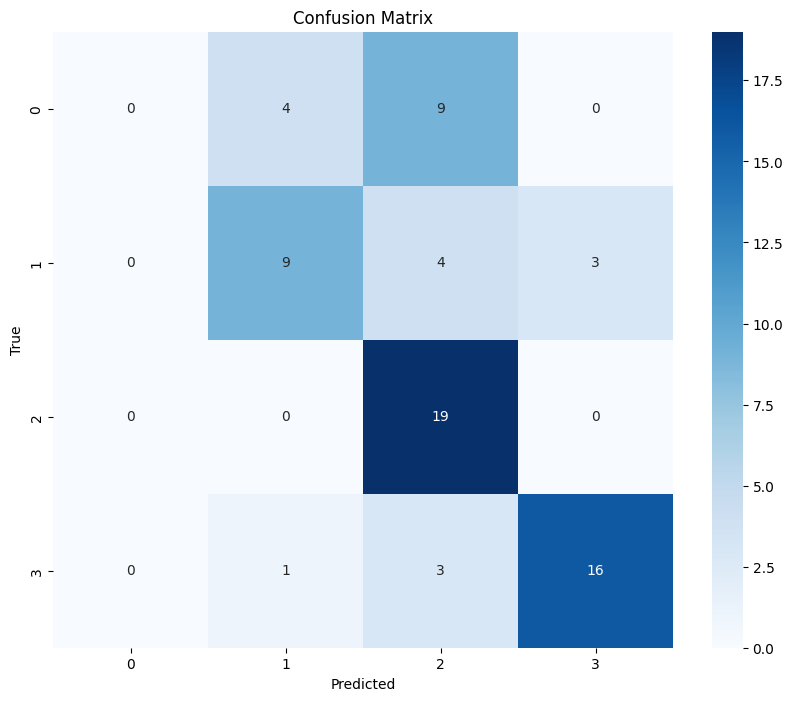

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [72]:
# added back the additional augmentation layer in make_df function
model_aug = build_mobilenet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [73]:
# train
model_aug.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2432 - loss: 3.3274

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.2467 - loss: 3.3065 - val_accuracy: 0.4247 - val_loss: 1.8398
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3247 - loss: 2.3739

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step - accuracy: 0.3254 - loss: 2.3551 - val_accuracy: 0.4110 - val_loss: 1.4901
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.3416 - loss: 1.6518

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - accuracy: 0.3426 - loss: 1.6502 - val_accuracy: 0.4110 - val_loss: 1.3731
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.3852 - loss: 1.6282

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.3868 - loss: 1.6156 - val_accuracy: 0.4932 - val_loss: 1.2261
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 701ms/step - accuracy: 0.3714 - loss: 1.3652 - val_accuracy: 0.4384 - val_loss: 1.2545
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - accuracy: 0.3883 - loss: 1.2781 - val_accuracy: 0.4110 - val_loss: 1.2909
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.3946 - loss: 1.2086 - val_accuracy: 0.4795 - val_loss: 1.2716
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.3461 - loss: 1.2402 - val_accuracy: 0.4932 - val_loss: 1.2618
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.3772 - loss: 1.1874 - val_accuracy: 0.4795 - val_loss: 1.2782
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.4581 - loss: 1.1628 - val_accuracy: 0.4110 - val_loss: 1.2885
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - accuracy: 0.4537 - loss: 1.1133 - val_accuracy: 0.4110 - val_loss: 1.2980
E

In [74]:
test_loss, test_acc = model_aug.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model_aug.evaluate(val_ds)
print(f"validation loss: {val_loss:.2f}, validation accuracy: {val_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.4938 - loss: 1.1573
test loss: 1.11, test accuracy: 0.57
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.3989 - loss: 1.2504
validation loss: 1.23, validation accuracy: 0.49


In [75]:
# Get predicted class indices
y_pred_prob = model_aug.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.60      0.38      0.46        16
           2       0.41      0.89      0.57        19
           3       0.94      0.80      0.86        20

    accuracy                           0.57        68
   macro avg       0.49      0.52      0.47        68
weighted avg       0.53      0.57      0.52        68



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

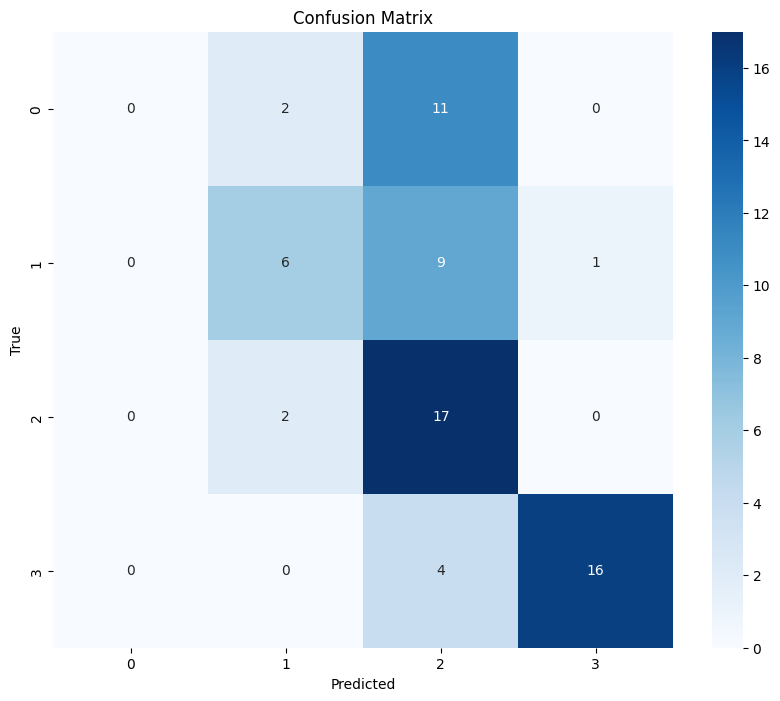

In [76]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [110]:
model3 = build_mobilenet_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [111]:
# train
model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 785ms/step - accuracy: 0.2829 - loss: 5.9393 - val_accuracy: 0.3699 - val_loss: 2.5677
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.2932 - loss: 4.6423 - val_accuracy: 0.3425 - val_loss: 1.5758
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.2262 - loss: 3.9172 - val_accuracy: 0.3836 - val_loss: 1.3372
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.3023 - loss: 2.9676 - val_accuracy: 0.4521 - val_loss: 1.2991
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.2623 - loss: 2.8850 - val_accuracy: 0.3973 - val_loss: 1.2859
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.2902 - loss: 2.5007 - val_accuracy: 0.2603 - val_loss: 1.3488
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 588ms/step - accuracy: 0.2394 - loss: 2.3141 - val_accuracy: 0.3151 - val_loss: 1.3117
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - accuracy: 0.2947 - loss: 1.9360 - val_accuracy: 0.4247 - val_loss

In [ ]:
test_loss, test_acc = model3.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model3.evaluate(val_ds)
print(f"validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.3934 - loss: 1.2504
test loss: 1.19, test accuracy: 0.41
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.4174 - loss: 1.3160
validation loss: 1.1874, validation accuracy: 0.4118


In [113]:
# Get predicted class indices
y_pred_prob = model3.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step
              precision    recall  f1-score   support

           0       0.28      0.85      0.42        13
           1       1.00      0.06      0.12        16
           2       0.00      0.00      0.00        19
           3       0.84      0.80      0.82        20

    accuracy                           0.41        68
   macro avg       0.53      0.43      0.34        68
weighted avg       0.54      0.41      0.35        68



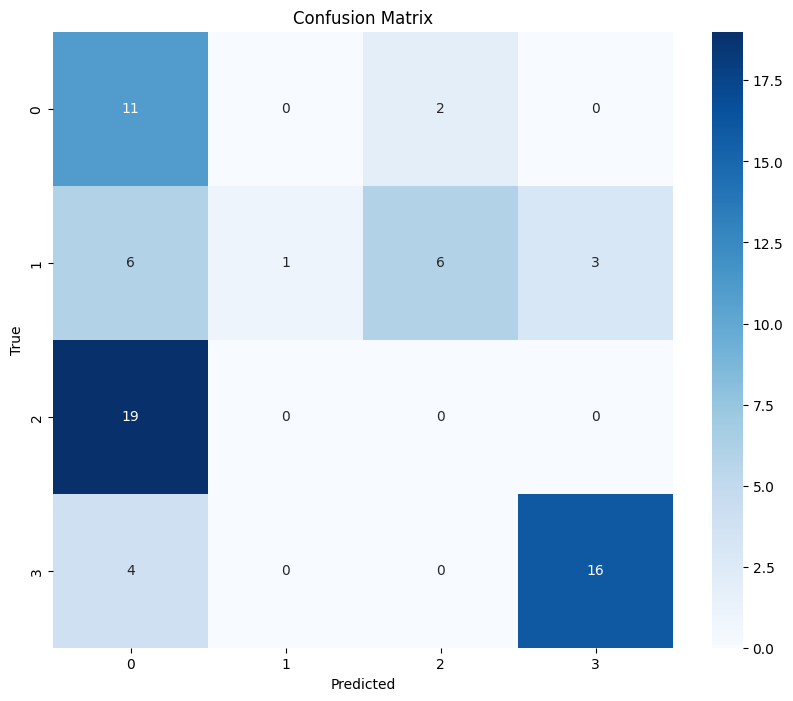

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()